# Проект: применение алгоритмов машинного обучения для предсказания рейтинга приложения в App Store 

# Загружаем данные/импортируем необходимые библиотеки

In [0]:
import numpy as np
import pandas as pd
import seaborn as sns

%pylab inline

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, learning_curve
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier

from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import f1_score

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

Populating the interactive namespace from numpy and matplotlib


In [0]:
data=pd.read_csv ("AppleStore.csv")

# Задачи и первичный анализ данных

Перед нами стоит задача предсказания оценки мобильного приложения в App Store. Для этого мы воспользуемся данными с сайта Kaggle, [ссылка](https://www.kaggle.com/ramamet4/app-store-apple-data-set-10k-apps).


Взглянем на данные:

In [0]:
data.head().T

,0,1,2,3,4
Unnamed: 0,1,2,3,4,5
id,281656475,281796108,281940292,282614216,282935706
track_name,PAC-MAN Premium,Evernote - stay organized,"WeatherBug - Local Weather, Radar, Maps, Alerts","eBay: Best App to Buy, Sell, Save! Online Shop...",Bible
size_bytes,100788224,158578688,100524032,128512000,92774400
currency,USD,USD,USD,USD,USD
price,3.99,0,0,0,0
rating_count_tot,21292,161065,188583,262241,985920
rating_count_ver,26,26,2822,649,5320
user_rating,4,4,3.5,4,4.5
user_rating_ver,4.5,3.5,4.5,4.5,5


Признаки:


---**id**: ID приложения (будем использовать данный признак как время, которое приложение провело в App Store).

---**track_name**: Название приложения.

---**size_bytes**: Размер в байтах.

---**currency**:  За какую валюту можно приобрести приложение.

---**price**: Цена.

---**rating_count_tot**: Количество оценивших приложение.


---**rating_count_ver**: Количество оценивших приложение (для текущей версии).

---**user_rating** : Средняя оценка (для всех версий).

---**user_rating_ver**:  Средняя оценка (для текущей версии).

---**ver **:  Код текущей версии (например, 1.0.2).

---**cont_rating**: Возраст, с которого можно пользоваться приложением.

---**prime_genre**: Жанр.

---**sup_devices.num**: Количество девайсов, на которых  приложение работает без помех.

---**ipadSc_urls.num**: Количество скриншотов работающего приложения.

---**lang.num**: Количество  поддерживаемых языков.

---**vpp_lic**: наличие Vpp-лицензии у приложения.






































Переименуем для удобства некоторые колонки:

In [0]:
col_name={'ipadSc_urls.num':'Screenshots','size_bytes':"Size", \
          'track_name':'AppName','lang.num':'SupportedLanguages',\
          'cont_rating':'ContentRating','user_rating':'Rating',\
          'prime_genre':'Genre','sup_devices.num':'DeviceNum',\
          'rating_count_tot':'RatingVotes','price':'Price','ver':"Version",\
          'vpp_lic':'VPPLicence','rating_count_ver':'RatingVotesCurVersion',\
          'user_rating_ver':'RatingCurVersion'}
data.rename(columns=col_name,inplace=True)

Размер приложения исчисляется в байтах, логично перевести их в МБ. Также  отмасштабируем размер id  - это никак не повлияет на конечный результат. 

In [0]:
# change to MB
data["id"]=data["id"]/1000000
data["Size(MB)"]=data["Size"]/1000000
data.drop(columns="Size",inplace=True)

Посмотрим на особенности датасета:

In [0]:
descr=data.describe().T
descr.round(0)
descr

,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,7197.0,4759.069612,3093.625213,1.000000,2090.000000,4380.000000,7223.000000,1.109700e+04
id,7197.0,863.130997,271.236756,281.656475,600.093661,978.148241,1082.309664,1.188376e+03
Price,7197.0,1.726218,5.833006,0.000000,0.000000,0.000000,1.990000,2.999900e+02
RatingVotes,7197.0,12892.907184,75739.408675,0.000000,28.000000,300.000000,2793.000000,2.974676e+06
RatingVotesCurVersion,7197.0,460.373906,3920.455183,0.000000,1.000000,23.000000,140.000000,1.770500e+05
Rating,7197.0,3.526956,1.517948,0.000000,3.500000,4.000000,4.500000,5.000000e+00
RatingCurVersion,7197.0,3.253578,1.809363,0.000000,2.500000,4.000000,4.500000,5.000000e+00
DeviceNum,7197.0,37.361817,3.737715,9.000000,37.000000,37.000000,38.000000,4.700000e+01
Screenshots,7197.0,3.707100,1.986005,0.000000,3.000000,5.000000,5.000000,5.000000e+00
SupportedLanguages,7197.0,5.434903,7.919593,0.000000,1.000000,1.000000,8.000000,7.500000e+01


Как можно заметить, большинство приложений - бесплатные.  Также можно отметить тот факт, что скриншотов к приложению может быть не более 5, а также что половина приложений поддерживают всего лишь 1 язык.


Давайте посмотрим на уникальные значения признака currency и VPPLicence.

In [0]:
data['currency'].unique()

array(['USD'], dtype=object)

Количество приложений без лицензии VPP: 50


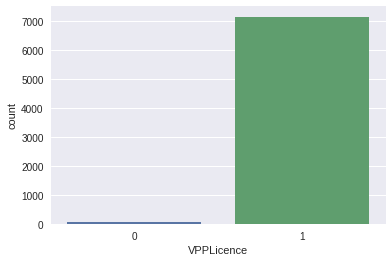

In [0]:
sns.countplot(x='VPPLicence',data=data)
print ('Количество приложений без лицензии VPP:',data.shape[0]-sum(data['VPPLicence']==1))

Видим, что первый признак не несет в себе никакой ценности, так как является константным. Второй же пока оставим - возможно, отсутствие лицензии негативно влияет на оценку приложения.

Для чистоты эксперимента создадим признак, который отвечает за количество  проголосвавших за предыдущую версию приложения, а признаки, которые отвечают за рейтинг текущей версии и количество проголосовавших - удалим. Также удалим название приложения.

In [0]:
data["RatingVotesPrevVersion"]=data["RatingVotes"]-data["RatingVotesCurVersion"]

In [0]:
data.drop(columns=["RatingCurVersion",'RatingVotesCurVersion',\
                   'RatingVotes','AppName'],inplace=True)

Также переименуем признак Rating в target.

In [0]:
data["target"]=data["Rating"]

Удаляем ненужные нам признаки, включая Unnamed 0 (индексы) и currency(константный признак).

In [0]:
data.drop(columns=["Unnamed: 0","currency","Rating"],inplace=True)

# Корреляционная матрица и анализ признаков

Давайте более детально взгялнем на признаки, с которыми мы работаем. Для начала построим матрицу корреляций. Воспользуемся корреляцией Спирмена - она гораздо лучше улавливает монотонную связь между признаками по сравнению с корреляцией Пирсона. 

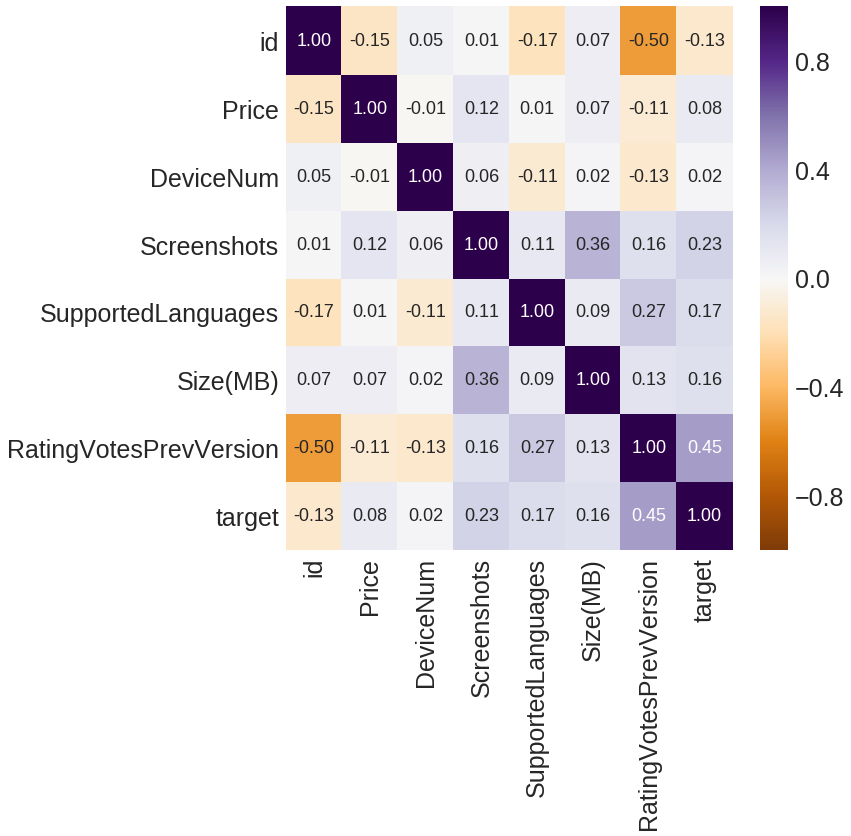

In [0]:
sns.set(font_scale=2.5)
pylab.figure(figsize=(10,10))
# Предварительно удалим бинарные признаки
corr_matrix=data.drop(columns=["VPPLicence"]).corr(method='spearman')
sns.heatmap(corr_matrix,annot=True,fmt = ".2f",cbar = True,cmap='PuOr',annot_kws={"size":18})

Рассмотрим некоторые интересные корреляции:

In [0]:
#Нам повезло - созданный нами ранее признак имеет довольно большую корреляцию с целевым.
print (corr_matrix['target']['RatingVotesPrevVersion'])

0.4510916012512443


In [0]:
#Чем дольше приложение находится в магазине, тем больше у нее отзывов.
print (corr_matrix['id']['RatingVotesPrevVersion'])

-0.5016740530960059


In [0]:
#Количество скриншотов связано с размером приложения.
print (corr_matrix['Size(MB)']['Screenshots'])
#Чем больше контента в приложении, тем больше можно показать на витрине.

0.3625697573899518


In [0]:
#В то же время, количество скриншотов влияет на целевую переменную.
print (corr_matrix['target']['Screenshots'])
#Больше контента - выше оценка

0.23225955101193405


И это означает, что размер тоже влияет на оценку:

In [0]:
print (corr_matrix['Size(MB)']['target'])

0.1612899358539128


И еще пару корреляций:

In [0]:
#Слабая, но интересная корреляция: 
print (corr_matrix['id']['SupportedLanguages'])
#Чем дольше приложение в магазине, тем больше языков поддерживается в приложении.

-0.17324165649445633


 Проверим связь между количеством языков и целевой переменной:

In [0]:
print (corr_matrix['target']['SupportedLanguages'])

0.1743903606790028


Действительно - чем больше языков в приложении, тем выше его оценка. 

In [0]:
print (corr_matrix['id']['target'])

-0.12644146911779044


Аналогичное явление наблюдаем в случае с id. Вывод прост - успешные проекты ведутся довольно долго, и получают большие оценки от пользователей.

# Работа с жанрами приложений

Text(0.5,1,'Количество приложений разных жанров')

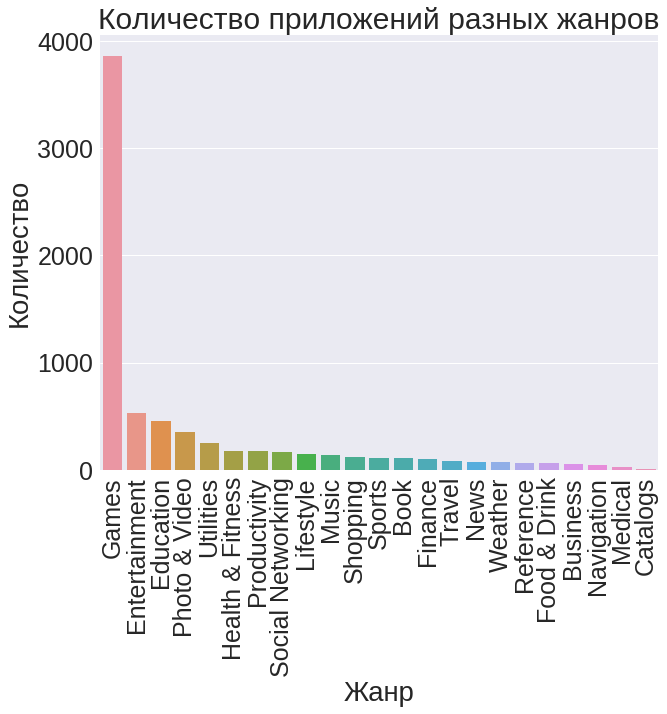

In [0]:
app_count=data["Genre"].value_counts().reset_index()

plt.figure(figsize = (10, 8), facecolor = None)
sns.set_style("darkgrid")
plot1 = sns.barplot(x="index", y="Genre", data=app_count)

plot1.set_xticklabels(app_count['index'], rotation=90)
plot1.set(xlabel='Жанр',ylabel='Количество')
plot1.set_title('Количество приложений разных жанров')

Строим график зависимости размера приложения от жанра:

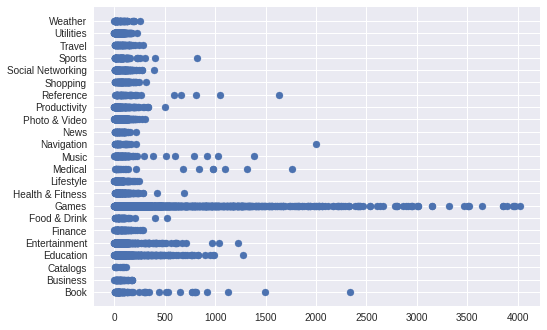

In [0]:
# size_genre_list=zip(data["Size(MB)"],data["Genre"])
sns.set(font_scale=1)
pylab.scatter(data["Size(MB)"],data["Genre"])


Как можно заметить из графика, наибольший размер  имеют игры .



Посмотрим, как распределены оценки по жанрам:

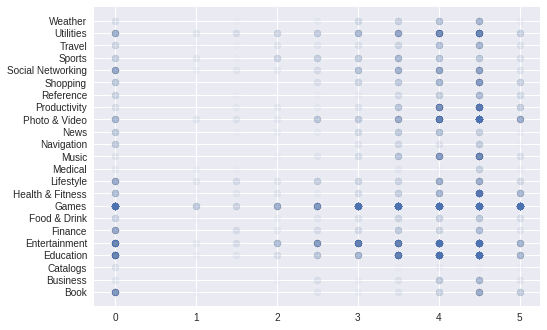

In [0]:
# size_genre_list=zip(data["Size(MB)"],data["Genre"])
sns.set(font_scale=1)
pylab.scatter(data["target"],data["Genre"],alpha=0.02)

Ничего необычного замечено не было. Игры, как лидер по количеству в App Store, получают много как положительных, так и отрицательных оценок.  

Распределение отзывов по жанрам:

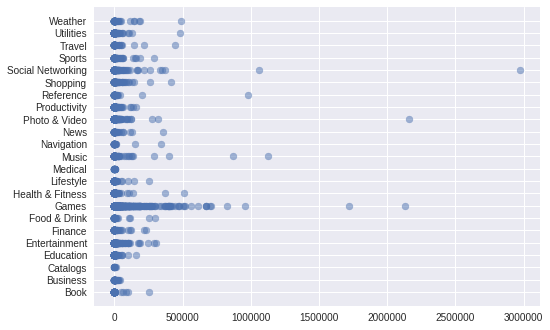

In [0]:
sns.set(font_scale=1)
pylab.scatter(data["RatingVotesPrevVersion"],data["Genre"],alpha=0.5)

Данный график интересен тем, что отзывы - один из самых скореллированных признаков с целевой переменной. Получаем, что если вы хотите создать успешное приложение, то желательно создать приложение, связанное с музыкой, соц. сетями или играми - до порога в 500000 отзывов доходит больше приложений именно этих жанров.

# Целевая переменная

Посмотрим на распределение нашей оценки:

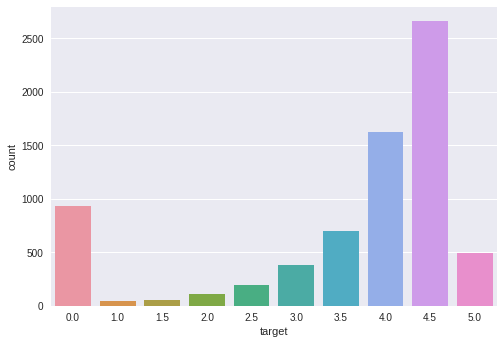

In [0]:
sns.countplot(x=data["target"])

Как можно заметить, большинство приложений имеет оценку 4-4.5 .В то же время есть приложения, которые совсем не получили оценку. Проблема заключается в том, что у нас почти нет данных о приложениях с оценками от 1 до 3. Давайте переведем нашу задачу из мультиклассовой классификации к бинарной (приложение получит хорошую оценку или нет).

Распределние целевой переменной имеет большой хвост - это приложения с рейтингом 0-3. Так как приложения с рейтингом 0 еще не оценили, то они могут вносить шум в данные. Удалим их.

In [0]:
data=data[data["target"]>0]

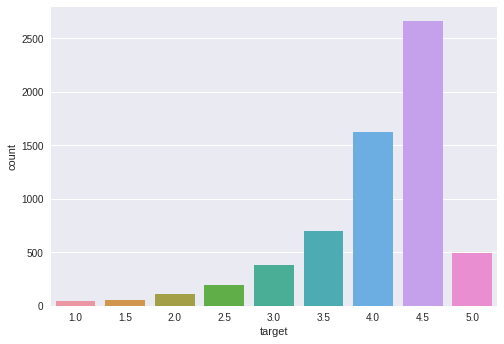

In [0]:
sns.countplot(x=data["target"])

Добавим величину, которая отвечает за "успех" приложения: 0, если оценка ниже или равна 4, 1 - если больше.

In [0]:
def categorize_rating(x):
    if x<=4:
        return 0
    else:
        return 1
      
data["target_bin"]=data["target"].apply(categorize_rating)

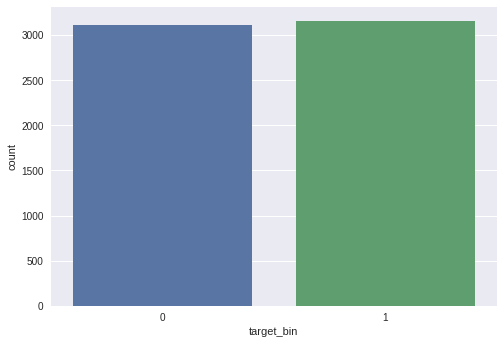

In [0]:
data.drop(columns=["target"],inplace=True)
sns.countplot(x=data["target_bin"])

Хотя выборка все еще не сбалансированна (объектов с рейтингом 1-3 крайне мало), теперь у нас есть достаточно данных для каждого из классов. 

# Работа с признаками и их обработка


Разобьем признаки на категориальные, бинарные и вещественые. 

In [0]:
cat_features=["ContentRating","Genre"]
bin_features=["VPPLicence"]
real_features=["id","Size(MB)",'Price','DeviceNum','Screenshots',\
               'SupportedLanguages',"RatingVotesPrevVersion"]
target=['target_bin']

Создадим для каждой группы свой DataFrame, и обработаем с помощью OneHotEncoder категориальные:

In [0]:
cat_data=data[cat_features]
bin_data=data[bin_features]
real_data=data[real_features]
target_data=data[target]

In [0]:
cat_data_encoded=pd.get_dummies(cat_data)

Соберем все признаки в 1 DataFrame, удалив целевую переменную.

In [0]:
restructured_data=pd.concat([cat_data_encoded,bin_data,real_data,target_data],axis=1)
target_column=restructured_data["target_bin"]
restructured_data.drop(columns=["target_bin"],inplace=True)

Разбиваем получившийся датасет на 2 датасета: обучение и тест.

In [0]:
X_train,X_test,Y_train,Y_test=train_test_split(restructured_data,target_column,\
                                               test_size=0.25,random_state=323,\
                                               stratify=target_column)

print  ('Датасет для обучения размером {} объектов'.format(X_train.shape[0]),\
        '\nДатасет для теста размером {} объекта'.format(X_test.shape[0]))

Датасет для обучения размером 4701 объектов 
Датасет для теста размером 1567 объекта


# Строим Baseline, выбираем метрику качества и отбираем признаки

Метрикой качества у нас выступает метрика F1 - мы хотим на выходе получить модель, которая:

---Находит все приложения с потенциальной оценкой >4


---Не дает высокую оценку неудачным приложениям

Так как данная метрика очень чувствительна к изменениям одного из ее компонентов, то она отлично подходит для нашей задачи.



Baseline - моделью будет выступать классификатор KNN (K-Nearest Neighbors). Это один из самых простых классификаторов, который делает прогнозы на основании k объектов, которые лежат ближе всего  по отношению к нему.

In [0]:
knn=KNeighborsClassifier (n_neighbors=10,weights="distance")
score=cross_val_score(knn,X_train,Y_train,cv=5,scoring='f1').mean ()
print ("F1 (cross-validation) score:{}".format(score))

F1 (cross-validation) score:0.5977525933549014


In [0]:
knn.fit (X_train,Y_train)
predictions=knn.predict(X_test)
baseline_score=f1_score (Y_test,predictions)
print ("F1 test score:{}".format(baseline_score))

F1 test score:0.576874205844981


Качество плохое, но этот резлуьтат ожидаемый - данный классификатор является одним из самых простых из известных на сегодняшний день.

Теперь давайте построим более сложную модель - RandomForestClassifier с количеством деревьев, равному 100. Заодно мы произведем отбор ненужных признаков, используя возможность случайного леса определять их важность, исходя из уменьшения критерия информативности.

Также добавим параметр class_weight='balanced' для того, чтобы объектам класса 0 давался больший вес при сделанной на них ошибке. (их меньше в выборке)

In [0]:
classifier=RandomForestClassifier (n_estimators=100,class_weight='balanced',random_state=123)
classifier.fit(X_train,Y_train)
score=cross_val_score(classifier,X_train,Y_train,cv=5,scoring='f1').mean()
print ("F1 (cross validation) score:{}".format(score))

F1 (cross validation) score:0.6554992102602543


Качество неплохое, но оставляет желать лучшего. Отберем признаки:

In [0]:
#Создадим пары важность-признак
feat_importance=np.array(classifier.feature_importances_)
feature_name_n_importance=[(importance,feat_name) for importance,feat_name in zip (feat_importance,restructured_data.columns)]

In [0]:
#Выведем на экран 30 самых важных признаков
feature_name_n_importance=sorted(feature_name_n_importance, key=lambda x:x[0],reverse=True)
list_of_stri=['Importance: {:.4f} Variable: {}'.format(*pair) for pair in feature_name_n_importance]
[print (stri) for stri in list_of_stri[0:30]]

#А также найдем количество признаков, которые в сумме дают 95% важности. (гиперпараметр, найден подбором).
total=0
num_of_feat=0
list_of_indices=np.array([])
for pair in feature_name_n_importance:
  if (total<0.95) and (np.isnan(pair[0])==False):
    total+=pair[0]
    num_of_feat+=1
    list_of_indices=np.append(list_of_indices,[pair[1]])
print ("\n98% важности хранится в {} признаках".format(num_of_feat)) #95%, опечатка

Importance: 0.2201 Variable: RatingVotesPrevVersion
Importance: 0.2026 Variable: id
Importance: 0.1871 Variable: Size(MB)
Importance: 0.0818 Variable: SupportedLanguages
Importance: 0.0615 Variable: Price
Importance: 0.0570 Variable: DeviceNum
Importance: 0.0388 Variable: Screenshots
Importance: 0.0170 Variable: Genre_Games
Importance: 0.0144 Variable: ContentRating_4+
Importance: 0.0119 Variable: Genre_Entertainment
Importance: 0.0113 Variable: ContentRating_12+
Importance: 0.0091 Variable: ContentRating_9+
Importance: 0.0086 Variable: ContentRating_17+
Importance: 0.0065 Variable: Genre_Education
Importance: 0.0059 Variable: Genre_Health & Fitness
Importance: 0.0058 Variable: Genre_Photo & Video
Importance: 0.0056 Variable: Genre_Utilities
Importance: 0.0053 Variable: Genre_Sports
Importance: 0.0048 Variable: Genre_Productivity
Importance: 0.0047 Variable: Genre_Book
Importance: 0.0046 Variable: Genre_Social Networking
Importance: 0.0043 Variable: Genre_Lifestyle
Importance: 0.0038 V

Создадим новый DataFrame с меньшим количеством признаков.

In [0]:
new_data=restructured_data[list_of_indices]

Снова разбиваем данные на обучение и тест, и проверим, как изменилось качество модели:

In [0]:
X_train,X_test,Y_train,Y_test=train_test_split(new_data,target_column,\
                                               test_size=0.25,random_state=323,\
                                               stratify=target_column)

print  ('Датасет для обучения размером {} объектов'.format(X_train.shape[0]),\
        '\nДатасет для теста размером {} объекта'.format(X_test.shape[0]))

Датасет для обучения размером 4701 объектов 
Датасет для теста размером 1567 объекта


In [0]:
classifier=RandomForestClassifier (n_estimators=100,class_weight="balanced",random_state=123)
classifier.fit(X_train,Y_train)
score=cross_val_score(classifier,X_train,Y_train,cv=5,scoring="f1").mean()
print ("F1 (cross validation) score:{}".format(score))

F1 (cross validation) score:0.6493536143272347


Нам удалось уменьшить пространство признаков вдвое, при этом качесатво качество классификации не сильно пострадало (-0.005). Значит, мы убрали шумовые признаки.

# Подбор модели и гиперпараметров

Начнем подбор модели. Добавим к случайному лесу градиентный бустинг, и с помощью перебора по сетке определим оптимальные гиперпараметры для алгоритмов.

In [0]:
classifiers = [GradientBoostingClassifier(random_state=123),
               RandomForestClassifier(class_weight='balanced',random_state=123)]
cls_name = ['GradientBoostingClassifier',
                    'RandomForestClassifier']

Определим гиперпараметры алгоритмов.

--- Количество деревьев в градиентном бустинге - от 50 до 150. Причина проста - при большом количестве деревьев бустинг склонен показывать примерно те же резузультаты, что и при количестве деревьев 50-150.



--- Также мы перебираем значения глубины дерева и коэффициент eta для каждого из новых алгоритмов.



--- Для случайного леса мы подбираем количество деревьев и количество  объектов в одном листе, при котором дальнейшие разбиения прекращаются. 




In [0]:
gb_params = {'n_estimators': [50,100,150],
              'learning_rate':[0.1,0.3,0.5],
              'max_depth': [3,5,10]}
rf_params= {'n_estimators': [100, 200, 300, 500], 
            'min_samples_leaf': [2,4,6,8,10]}

In [0]:
%%time
fits=[]
scores=[]
params = [gb_params, rf_params]
np.random.seed(42)
for i, each_classifier in enumerate(classifiers):
    cur_classifier= each_classifier
    cls_params = params[i]
    grid = GridSearchCV(cur_classifier, cls_params, 
                        cv=5,
                        scoring='f1')
    grid.fit(X_train, Y_train)
    fits.append(grid.best_params_)
    cls_best_score = grid.best_score_
    scores.append(cls_best_score)
    print(cls_name[i], cls_best_score, "\n", grid.best_params_, "\n")

GradientBoostingClassifier 0.6575863492833498 
 {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 150} 

RandomForestClassifier 0.6590121775937786 
 {'min_samples_leaf': 2, 'n_estimators': 100} 

CPU times: user 5min 19s, sys: 80.8 ms, total: 5min 19s
Wall time: 5min 19s


С подбором гиперпараметров качество классификации снова улучшилось. Оба алгоритма показывают примерно одинаковый резлуьтат, но на практике себя лучше показал алгоритм RandomForest - его мы и будем использовать. 

Проведем более глубокий подбор гиперпараметров:

In [0]:
%%time
rf_deep_params= {'n_estimators': [50,75,100,125,150,175,200],
                 'min_samples_leaf': [2,4,6,8,10]}
rf_classifier=RandomForestClassifier(class_weight='balanced',random_state=123)
grid_rf=GridSearchCV(rf_classifier,rf_deep_params,cv=5,scoring="f1")
grid_rf.fit(X_train,Y_train)

CPU times: user 2min 3s, sys: 33.9 ms, total: 2min 3s
Wall time: 2min 3s


In [0]:
print("F1 (cross validation with hyperparameter tuning) score:",grid_rf.best_score_,'\n',grid_rf.best_params_)

F1 (cross validation with hyperparameter tuning) score: 0.6591347968804385 
 {'min_samples_leaf': 2, 'n_estimators': 150}


Качество клафссификации снова улучшилось. Посмотрим на важность признаков:

In [0]:
#Создадим пары важность-признак
feat_importance=np.array(grid_rf.best_estimator_.feature_importances_)
feature_name_n_importance=[(importance,feat_name) for importance,feat_name in zip (feat_importance,new_data.columns)]

In [0]:
#Выведем на экран 30 самых важных признаков
print ("___________________________________\n")
feature_name_n_importance=sorted(feature_name_n_importance, key=lambda x:x[0],reverse=True)
list_of_stri=['Importance: {:.4f} Variable: {}'.format(*pair) for pair in feature_name_n_importance]
[print (stri) for stri in list_of_stri[0:30]]
print ("\n___________________________________")

___________________________________

Importance: 0.2526 Variable: RatingVotesPrevVersion
Importance: 0.2132 Variable: id
Importance: 0.1851 Variable: Size(MB)
Importance: 0.0845 Variable: SupportedLanguages
Importance: 0.0626 Variable: Price
Importance: 0.0526 Variable: DeviceNum
Importance: 0.0377 Variable: Screenshots
Importance: 0.0237 Variable: Genre_Games
Importance: 0.0162 Variable: ContentRating_4+
Importance: 0.0150 Variable: Genre_Entertainment
Importance: 0.0113 Variable: ContentRating_12+
Importance: 0.0094 Variable: ContentRating_9+
Importance: 0.0077 Variable: ContentRating_17+
Importance: 0.0062 Variable: Genre_Education
Importance: 0.0062 Variable: Genre_Photo & Video
Importance: 0.0058 Variable: Genre_Health & Fitness
Importance: 0.0052 Variable: Genre_Utilities
Importance: 0.0051 Variable: Genre_Sports

___________________________________


Исходя из этой таблицы, мы можем с уверенностью сказать, что сильнее всего влияет на успешность приложения.

# Построение кривых обучения

In [0]:
def plot_with_std(x, data, **kwargs):
        mu, std = data.mean(1), data.std(1)
        lines = plt.plot(x, mu, '-', **kwargs)
        plt.fill_between(x, mu - std, mu + std, edgecolor='none',
                         facecolor=lines[0].get_color(), alpha=0.2)
        
def plot_learning_curve(clsf, X, y, scoring, cv=5):
 
    train_sizes = np.linspace(0.05, 1, 20)
    n_train, val_train, val_test = learning_curve(clsf,
                                                  X, y, train_sizes=train_sizes,
                                                  cv=cv, scoring=scoring)
    plot_with_std(n_train, val_train, label='training scores', c='green')
    plot_with_std(n_train, val_test, label='validation scores', c='red')
    plt.xlabel('Training Set Size'); plt.ylabel(scoring)
    plt.legend()

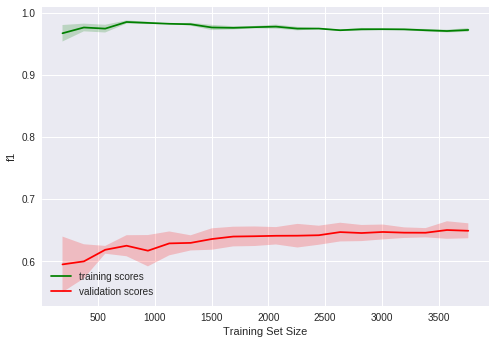

In [0]:
plot_learning_curve(grid_rf.best_estimator_,
                   X_train, Y_train, scoring='f1', cv=5)

Отметим важную особенность - кривые не  сошлись. Значит, при увеличении количества данных мы сможем увеличить результат.

# Результаты на тестовой выборке

In [0]:
predictions=grid_rf.best_estimator_.predict (X_test)
score=f1_score (predictions,Y_test)

In [0]:
print ("Current test score: {}".format(score),"vs baseline score: {}".format (baseline_score))

Current test score: 0.6424242424242423 vs baseline score: 0.576874205844981


# Выводы

1. Мы определили, что наибольше влияет на оценку приложений в App Store (см. разделы "Работа с жанрами", "Подбор модели и гиперпараметров" и "Корреляционная матрица и анализ признаков"). Это один из важнейших результатов, так как разработчики будут знать ключевые факторы, которые влияют на оценку их работы.

2. Хотя мы получили не особо впечатляющий результат (метрика F1 -  0.6424), это можно объяснить нехваткой данных (см. раздел "Построение кривой обучения"). При увеличении количества объектов можно достичь результатов  ~ 0.75-0.9 по метрике F1.


3.Также, для улучшения качества модели можно принять такие шаги:

      - Стакинг текущей модели с моделью(-ями) градиентного бустинга.
      - Чистка датасета от шумовых объектов.